In [3]:
import os
from PIL import Image
import glob
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import *
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing.image import *
from matplotlib import pyplot as plt

<h5> Photos are uploaded from a folder which contains all the Aligned and Cropped images of the UTKFace Dataset. 
    <br>
    </h5> 
    <p>Link of the dataset: <a href =  https://susanqq.github.io/UTKFace/> 
     https://susanqq.github.io/UTK </a>
</p>
<p> Age is extracted from the filename of the image. Images are resized to 50x50 pixels. </p>



In [8]:
image_list = []
img_age = []

for filename in glob.glob('UTKFace/*.jpg'):  
    filename = str(filename)
    img_age.append(filename[filename.find("\\")+1:filename.find("_")])
    im = cv2.imread(filename)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (50,50))
    image_list.append(np.asarray(im))


data = np.array(image_list)
labels = np.array(img_age).astype(np.float)

<h5> It can be seen that data is not equally distributed, Nearly 10% of the data comes from 26 year olds. </h5>

In [9]:
df = pd.DataFrame(labels, columns = ["Age"])

df["Age"].value_counts(normalize = True).head(10)

26.0    0.092669
1.0     0.047368
28.0    0.038721
35.0    0.037118
24.0    0.036232
25.0    0.030960
30.0    0.030538
32.0    0.028007
27.0    0.025941
29.0    0.024043
Name: Age, dtype: float64

<h5> Visualizing the distribution of data: </h5>

D:\Uygulamalar\Anaconda\envs\myenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

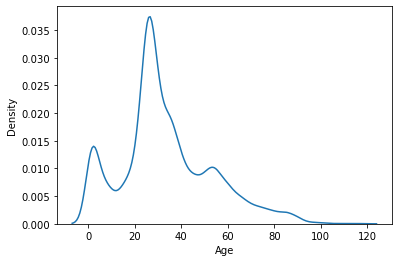

In [10]:
sns.distplot(df["Age"], hist = False)

<h5>To better understand the distribution, we make a quantile based binning of the ages.</h5>

In [11]:
df["bins"] = pd.qcut(df["Age"], 10)

df.groupby("bins").count()

,Age
bins,
"(0.999, 6.0]",2494
"(6.0, 20.0]",2383
"(20.0, 25.0]",2760
"(25.0, 26.0]",2197
"(26.0, 29.0]",2103
"(29.0, 34.0]",2290
"(34.0, 40.0]",2773
"(40.0, 50.0]",2100
"(50.0, 61.0]",2372


<h5>Binning the data into age groups. 
<br>
<br>    
I did this binning considering the distribution of the data, but I also wanted every class to be similar and logical in itself.

</h5>

In [12]:
i = 0

while i < len(labels):
    if labels[i] >= 0 and labels[i] < 4:
        labels[i] = 0
    elif labels[i] >= 4 and labels[i] < 13:
        labels[i] = 1
    elif labels[i] >= 13 and labels[i] < 21:
        labels[i] = 2
    elif labels[i] >= 21 and labels[i] < 31:
        labels[i] = 3
    elif labels[i] >= 31 and labels[i] < 46:
        labels[i] = 4
    elif labels[i] >= 46 and labels[i] < 65:
        labels[i] = 5
    elif labels[i] >= 65:
        labels[i] = 6
    i += 1
    
age_dict = {
    0:"0-3",
    1:"4-12",
    2:"13-20",
    3:"21-30",
    4:"31-45",
    5:"46-64",
    6:"65+",

}

<h5>Size of the classes: </h5>

In [13]:
pd.Series(labels).value_counts().sort_index()

0.0    1894
1.0    1519
2.0    1464
3.0    7784
4.0    5434
5.0    3655
6.0    1958
dtype: int64

<h5>Splitting the data: </h5>

In [14]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size = 0.2)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5)

In [15]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(18966, 50, 50, 3)
(2371, 50, 50, 3)
(2371, 50, 50, 3)


<h5>There aren't too many images, so I used the Data Generator class of Keras for Data Augmentation.
<br>
    <br>
I only inserted newly created images to training set, not to the validation or test sets.</h5>

In [16]:
datagen = ImageDataGenerator()

datagen.fit(X_train)
X_batch = datagen.flow(X_train, y_train, batch_size=32)

X_aug = []
y_aug = []

for i in range(0,len(X_batch)):
    batch = X_batch[i]
    for elem in batch[:][0]:
        X_aug.append(elem)
    for elem in batch[:][1]:
        y_aug.append(elem)
        
X_aug = np.array(X_aug)        
y_aug = np.array(y_aug)

X_train = np.append(X_train, X_aug, axis = 0)
y_train = np.append(y_train, y_aug, axis = 0)

In [17]:
X_train.shape

(37932, 50, 50, 3)

In [18]:
train_size = X_train.shape[0]

val_size = X_val.shape[0]

train = tf.data.Dataset.from_tensor_slices((X_train, to_categorical(y_train)))
train = train.shuffle(train_size).batch(32)

val = tf.data.Dataset.from_tensor_slices((X_val, to_categorical(y_val)))
val = val.shuffle(val_size).batch(32)

In [19]:
del X_train
del X_val
del y_train
del y_val

del X_aug
del y_aug

<h5>Model</h5>

In [20]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters = 128, kernel_size = 3),  
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(filters = 64, kernel_size = 3),    
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(filters = 64, kernel_size = 3),    
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Dense(32, activation = "relu"),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(7, activation = "sigmoid")
])

In [23]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'checkpoint.hdf5',
    save_weights_only = True,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1,
    save_best_only=True)

In [24]:
opt = Adam()

model.compile(
  opt,
  loss='categorical_crossentropy',
  metrics=["accuracy"])


model.fit(
  train,
  epochs=15,
  validation_data=val,
  callbacks=[model_checkpoint_callback]
)

Epoch 1/15
1186/1186 [==============================] - 70s 40ms/step - loss: 1.3508 - accuracy: 0.4666 - val_loss: 2.2319 - val_accuracy: 0.2261

Epoch 00001: val_accuracy improved from -inf to 0.22606, saving model to checkpoint.hdf5
Epoch 2/15
1186/1186 [==============================] - 47s 39ms/step - loss: 0.9697 - accuracy: 0.5950 - val_loss: 1.1551 - val_accuracy: 0.4901

Epoch 00002: val_accuracy improved from 0.22606 to 0.49009, saving model to checkpoint.hdf5
Epoch 3/15
1186/1186 [==============================] - 50s 42ms/step - loss: 0.8840 - accuracy: 0.6282 - val_loss: 1.5498 - val_accuracy: 0.4369

Epoch 00003: val_accuracy did not improve from 0.49009
Epoch 4/15
1186/1186 [==============================] - 47s 39ms/step - loss: 0.8082 - accuracy: 0.6646 - val_loss: 1.4254 - val_accuracy: 0.4150 - loss: 0.8072 - accuracy - ETA: 6s - loss: 0.8 - ETA: 5s - - ETA: 3s - loss: 0.8077 - accuracy - ETA: 3s - loss: 0.807 - ETA: 2s - l - ETA:  - ETA: 0s - loss: 0.8082 - accuracy

In [25]:
model.load_weights("checkpoint.hdf5")

<h5>Total accuracy and Classwise Accuracy Scores </h5>

In [26]:
model_pred = model.predict(X_test)
score = np.max(model_pred, axis = 1)
pred = np.argmax(model_pred, axis = 1)


df = pd.DataFrame(columns = ["Actual","Pred","Score"])


df["Actual"] = y_test.astype("int")
df["Pred"] = pred
df["Score"] = score


Accuracy = (len(df.query("Actual == Pred"))/len(df))*100

print("Accuracy of the model: ", Accuracy)

class_accuracy = {}

for elem in set(df["Actual"]):  
    class_accuracy[age_dict[elem]] = (len(df.loc[(df["Actual"] == elem) & (df["Pred"] == elem)])/len(df.loc[df["Actual"] == elem]))*100
    print("Accuracy of Class", age_dict[elem], ":",class_accuracy[age_dict[elem]])
  

Accuracy of the model:  60.26992830029524
Accuracy of Class 0-3 : 86.74033149171271
Accuracy of Class 4-12 : 74.53416149068323
Accuracy of Class 13-20 : 28.915662650602407
Accuracy of Class 21-30 : 72.31182795698925
Accuracy of Class 31-45 : 45.884413309982484
Accuracy of Class 46-64 : 53.48189415041783
Accuracy of Class 65+ : 59.25925925925925


<h5>Model is successful when it comes to predicting age group 0-3, but it is not as accurate when it comes down to middle age, especially for the second class, which consists of ages 13-20, so I wanted to see what are the predictions of the model for Class 2.
</h5>

In [27]:
df.loc[df["Actual"] == 2].groupby(["Actual","Pred"]).count().rename(columns = {"Score":"Count"})

Count
Actual Pred       
2      0         1
       1        28
       2        48
       3        68
       4        18
       5         3

<h5> Plotting Actual values and model predictions for all the classes. I think it is normal that most mistakes are made with the neighboring classes, for example model has confused 65+ ages mostly with 46-64. 
    <br>
    <br>
    Thinking from a human perspective, this is pretty normal, since a human is also most likely to make a wrong prediction of a class with its neighboring one.
    <h5>

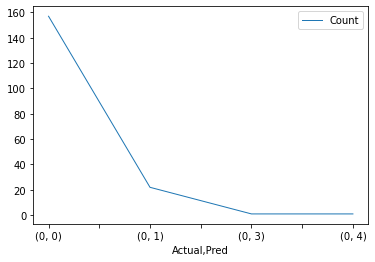

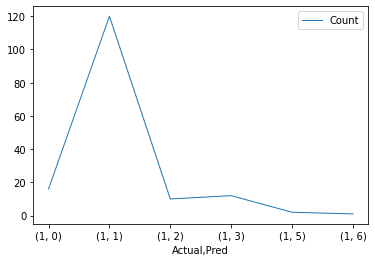

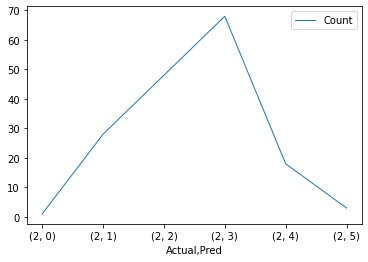

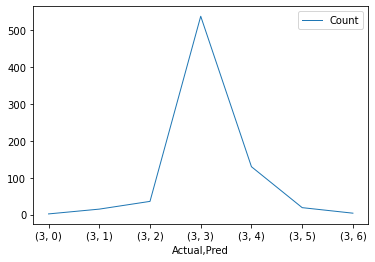

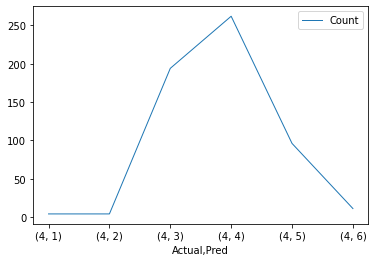

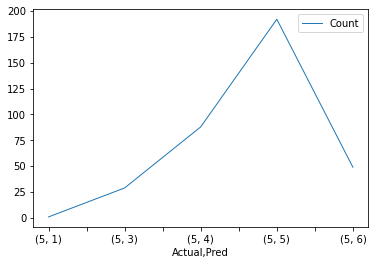

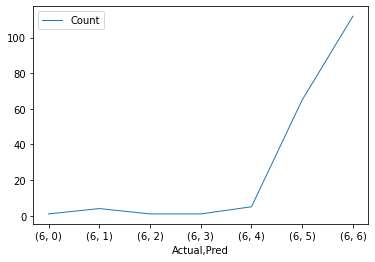

In [28]:
for age_group in set(df["Actual"]):
    df.loc[df["Actual"] == age_group].groupby(["Actual","Pred"]).count().rename\
                                      (columns = {"Score":"Count"}).plot(linewidth = 1)

<h5>100 images which the model has falsely predicted: </h5>

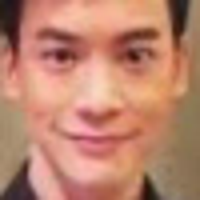

Actual: 31-45 
Pred: 21-30
Score: 0.9343982


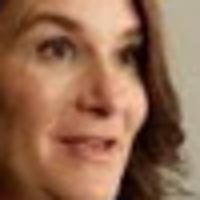

Actual: 31-45 
Pred: 46-64
Score: 0.900119


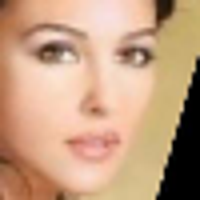

Actual: 13-20 
Pred: 21-30
Score: 0.8981332


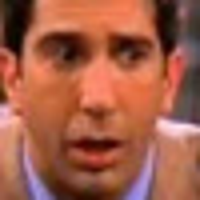

Actual: 21-30 
Pred: 31-45
Score: 0.8658291


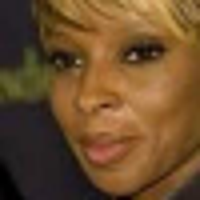

Actual: 46-64 
Pred: 21-30
Score: 0.58957475


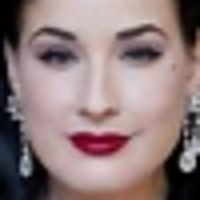

Actual: 31-45 
Pred: 21-30
Score: 0.98537946


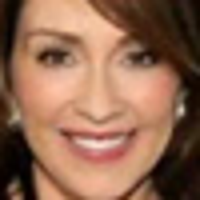

Actual: 46-64 
Pred: 21-30
Score: 0.9641671


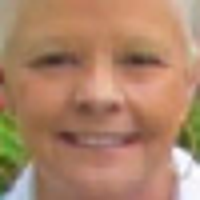

Actual: 65+ 
Pred: 4-12
Score: 0.6098466


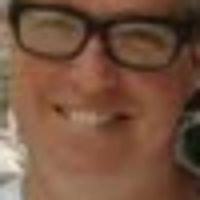

Actual: 46-64 
Pred: 31-45
Score: 0.31573737


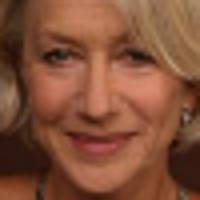

Actual: 65+ 
Pred: 46-64
Score: 0.8766139


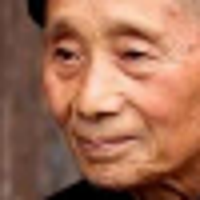

Actual: 46-64 
Pred: 65+
Score: 0.99984825


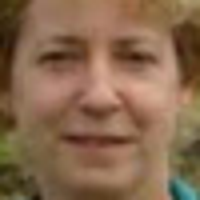

Actual: 31-45 
Pred: 46-64
Score: 0.90919816


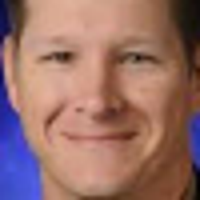

Actual: 31-45 
Pred: 46-64
Score: 0.64151454


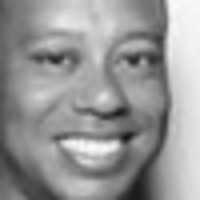

Actual: 31-45 
Pred: 21-30
Score: 0.8497059


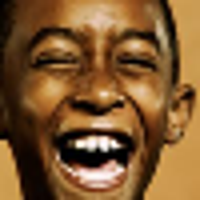

Actual: 4-12 
Pred: 46-64
Score: 0.99472946


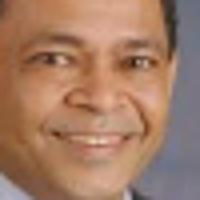

Actual: 31-45 
Pred: 46-64
Score: 0.9984963


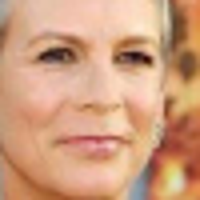

Actual: 46-64 
Pred: 65+
Score: 0.9938585


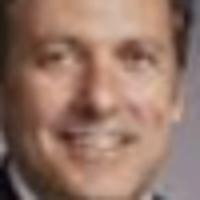

Actual: 31-45 
Pred: 46-64
Score: 0.9485288


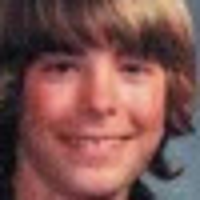

Actual: 13-20 
Pred: 31-45
Score: 0.834267


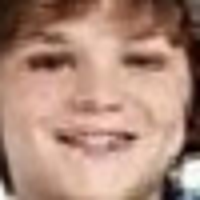

Actual: 4-12 
Pred: 13-20
Score: 0.7041816


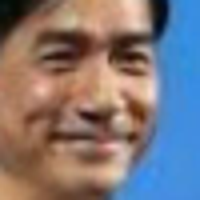

Actual: 46-64 
Pred: 31-45
Score: 0.9306512


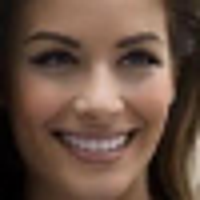

Actual: 21-30 
Pred: 31-45
Score: 0.8037975


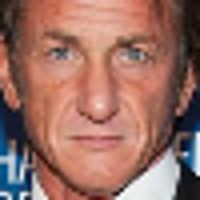

Actual: 46-64 
Pred: 65+
Score: 0.9557358


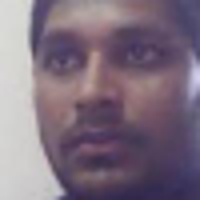

Actual: 21-30 
Pred: 31-45
Score: 0.7872297


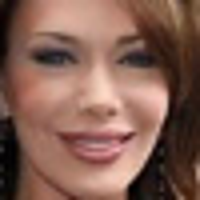

Actual: 31-45 
Pred: 21-30
Score: 0.8921466


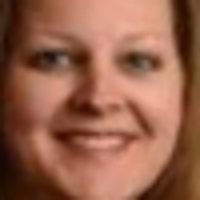

Actual: 31-45 
Pred: 46-64
Score: 0.94691753


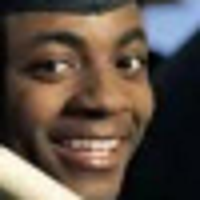

Actual: 21-30 
Pred: 31-45
Score: 0.8933457


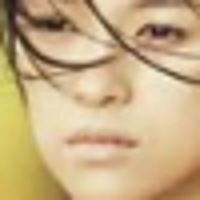

Actual: 21-30 
Pred: 65+
Score: 0.39420694


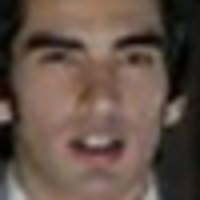

Actual: 31-45 
Pred: 21-30
Score: 0.993807


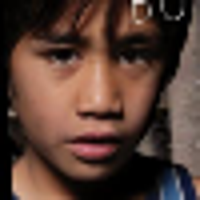

Actual: 4-12 
Pred: 13-20
Score: 0.965435


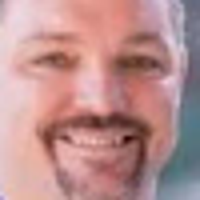

Actual: 65+ 
Pred: 31-45
Score: 0.70853394


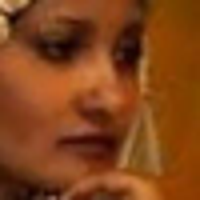

Actual: 31-45 
Pred: 21-30
Score: 0.8653317


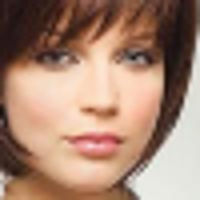

Actual: 21-30 
Pred: 13-20
Score: 0.959734


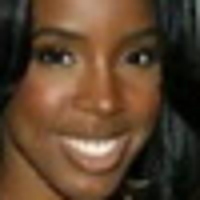

Actual: 31-45 
Pred: 21-30
Score: 0.9827824


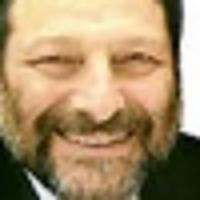

Actual: 46-64 
Pred: 65+
Score: 0.98822093


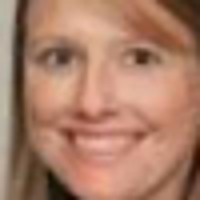

Actual: 46-64 
Pred: 31-45
Score: 0.7715107


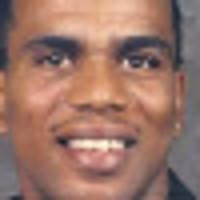

Actual: 46-64 
Pred: 31-45
Score: 0.9542011


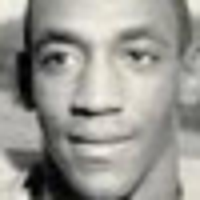

Actual: 21-30 
Pred: 31-45
Score: 0.6502223


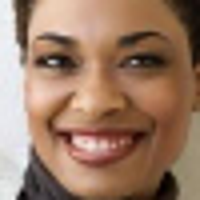

Actual: 31-45 
Pred: 21-30
Score: 0.91530794


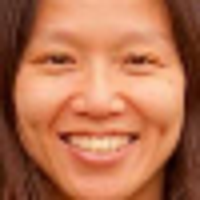

Actual: 21-30 
Pred: 31-45
Score: 0.6952605


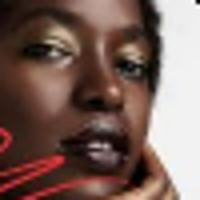

Actual: 21-30 
Pred: 65+
Score: 0.6771738


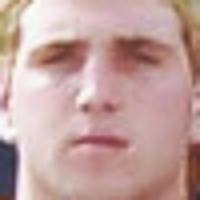

Actual: 13-20 
Pred: 21-30
Score: 0.65203536


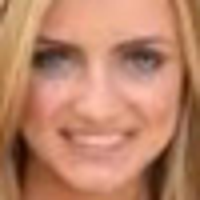

Actual: 13-20 
Pred: 21-30
Score: 0.57737917


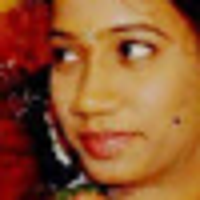

Actual: 31-45 
Pred: 21-30
Score: 0.88688606


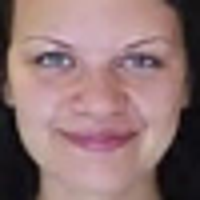

Actual: 31-45 
Pred: 13-20
Score: 0.39923835


In [29]:
i = 0
wrong_indexes = df.query("Actual != Pred").index.values

while i < 100:
    if i in wrong_indexes:
        display(Image.fromarray(X_test[i],"RGB").resize((200,200)))
        print("Actual:",age_dict[y_test[i]],"\nPred:", age_dict[pred[i]])
        print("Score:", score[i])
    i += 1

<h5> A function to predict an image outside of the dataset. </h5>

In [30]:
def predict(inp):
    if str(type(inp)) == "<class 'PIL.JpegImagePlugin.JpegImageFile'>":
        score = np.max((model.predict(np.expand_dims(np.array(inp.resize((50,50))), axis = 0))*100).round())
        group = np.argmax(model.predict(np.expand_dims(np.array(inp.resize((50,50))), axis = 0)))
        display(inp.resize((250,250)))
        print("Possible Age Group:",age_dict[group])
        print("Score:",score)
    elif str(type(inp)) ==  "<class 'list'>":  
        for elem in inp:
            score = np.max((model.predict(np.expand_dims(np.array(elem.resize((50,50))), axis = 0))*100).round())
            group = np.argmax(model.predict(np.expand_dims(np.array(elem.resize((50,50))), axis = 0)))
            display(inp.resize((250,250)))
            print("Tahmini Yaş Grubu:",age_dict[group],"\n")
            print("Score:",score)          
    else:
        print("Wrong Data Type!")